**21. Hyperparameter tuning in PyTorch using Optuna**

`Hyperparameters that would be tuned`
1. Number of hidden layers 
2. Neurons per layer 
3. Number of Epochs 
4. Optimizer 
5. Learning rate 
6. Batch Size 
7. Dropout rate 
8. Weight decay ($\lambda$) 

`Optuna code overlay`
1. Objective function:
   * Define
      * Search space
      * model init
      * param init
      * training loop
      * evaluation loop
    * returns
      * accuracy on validation data/test data


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# hyperparameter tuning
import optuna

# set random seeds for reproducibility
random_seed = 14

In [2]:
df = pd.read_csv('datasets/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


*Data preprocessing and DataLoader creation*

**`4. Other data improvements for GPU`**

* increase the batch size
* set `pin_memory = True` in DataLoader 

In [3]:
# getting data as numpy arrays
X = df.drop(columns=['label']).to_numpy()
y = df['label'].to_numpy()

class_labels =  ["T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"]

# perform train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# convert the arrays into pytorch tensors
X_train_tensor = tr.tensor(X_train, dtype= tr.float32)
X_test_tensor = tr.tensor(X_test, dtype= tr.float32) 
y_train_tensor = tr.tensor(y_train, dtype= tr.long) 
y_test_tensor = tr.tensor(y_test, dtype= tr.long) 

# creating dataset class
class FMNIST_DATASET(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.normalize(self.X[index]),self.y[index]

    def normalize(self,X):
        return (X/255.0).astype(np.float32)
    
train_dataset = FMNIST_DATASET(X_train,y_train)
test_dataset = FMNIST_DATASET(X_test,y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset,batch_size= BATCH_SIZE, shuffle = False)

*Image Visualization*

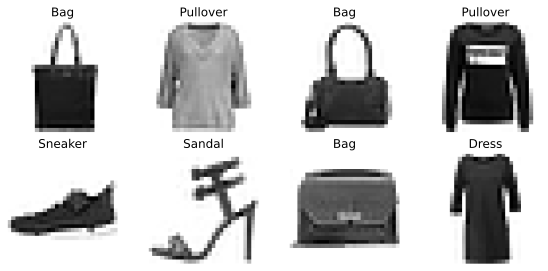

In [4]:
fig,axes = plt.subplots(2,4,figsize = (8,4))

images,labels = next(iter(train_loader))


for i,ax in enumerate(axes.flat):
    img = images[i].reshape(28,28)
    ax.imshow(img,cmap = 'binary')
    ax.axis('off')
    ax.set_title(f'{class_labels[labels[i]]}')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

**Defining Optuna Objective function**

In [5]:
class FMNIST_NET(nn.Module):
    def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer,p_dropout = 0.3):
        super().__init__()
        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim,neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p_dropout))
            input_dim = neurons_per_layer  
        
        layers.append(nn.Linear(neurons_per_layer,output_dim))
        self.model = nn.Sequential(*layers) # nn.Sequential needs individual layers, hence we unpack the list using `*`
        
    def forward(self,x):
        return self.model(x)

# from torchinfo import summary
# demo_model = FMNIST_NET(784,10,5,16)
# summary(demo_model)

In [6]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [7]:
def objective(trial: optuna.trial):
    # next hyperparams values from search space
    num_hidden_layers = trial.suggest_int('num_hidden_layers',1,5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer",8,128,step = 8)
    p_dropout = trial.suggest_float('dropout_rate',0.1,0.5,step = 0.1)


    # handling batch-size
    BATCH_SIZE = trial.suggest_categorical('batch_size',[16,32,64,128])
    train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE, shuffle = True)
    test_loader = DataLoader(test_dataset,batch_size= BATCH_SIZE, shuffle = False)

    # model initialization
    input_dim = 784
    output_dim = 10

    model = FMNIST_NET(input_dim = input_dim,
                       output_dim = output_dim,
                       num_hidden_layers = num_hidden_layers,
                       neurons_per_layer = neurons_per_layer,
                       p_dropout = p_dropout)
    
    ### add model to GPU if available
    model.to(device)

    # other parameters initialization
    learning_rate = trial.suggest_float('learning_rate',1e-5,1e-1,log = True)
    epochs = trial.suggest_int("epochs",10,50,step = 10)

    # loss and optimizer selection
    loss_fn = nn.CrossEntropyLoss()
    weight_decay = trial.suggest_float('weight_decay',1e-5,1e-3,log = True)
    optimizer_name = trial.suggest_categorical('optimizer',['Adam','SGD','RMSProp'])
    
    match optimizer_name:
        case 'Adam':
            optimizer = tr.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)
        case 'SGD':
            optimizer = tr.optim.SGD(model.parameters(),lr = learning_rate)
        case 'RMSProp':
            optimizer = tr.optim.RMSprop(model.parameters(),lr = learning_rate, weight_decay=weight_decay)
        case _:
            optimizer = tr.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)


    # training loop  
    for epochi in range(epochs):
        model.train()
        for X_batch,y_batch in train_loader:
            # moving data to device (GPU)
            X_batch,y_batch = X_batch.to(device),y_batch.to(device)
            
            # forward pass
            y_pred = model(X_batch)

            # loss calculation
            loss = loss_fn(y_pred,y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # upgrade parameters
            optimizer.step()

        
        # perform validation
        model.eval()
        val_correct = 0
        val_total = 0

        with tr.no_grad(): # disable gradient tracking
            for X_val,y_val in test_loader:
                # moving data to device(GPU)
                X_val,y_val = X_val.to(device),y_val.to(device)
                
                y_pred = model(X_val)
                preds = tr.argmax(y_pred,dim=1)
                val_correct += (preds == y_val).sum().item()
                val_total += y_val.size(0)
        accuracy = (val_correct / val_total)*100

    # return parameter to be optimized
    return accuracy

In [8]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler())
study.optimize(objective,n_trials=50)

[I 2025-05-29 11:43:46,737] A new study created in memory with name: no-name-4074ddcf-29f4-4b30-bdb7-437ca2aaaafe
[I 2025-05-29 11:43:50,337] Trial 0 finished with value: 62.083333333333336 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 104, 'dropout_rate': 0.4, 'batch_size': 64, 'learning_rate': 0.005100990188563874, 'epochs': 10, 'weight_decay': 0.0006030572806877948, 'optimizer': 'SGD'}. Best is trial 0 with value: 62.083333333333336.
[I 2025-05-29 11:44:04,549] Trial 1 finished with value: 46.58333333333333 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 32, 'dropout_rate': 0.1, 'batch_size': 32, 'learning_rate': 1.9860708707177768e-05, 'epochs': 50, 'weight_decay': 1.7267872859730894e-05, 'optimizer': 'SGD'}. Best is trial 0 with value: 62.083333333333336.
[I 2025-05-29 11:44:18,713] Trial 2 finished with value: 83.25 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 72, 'dropout_rate': 0.1, 'batch_size': 32, 'learning_rate': 0.009696413197

In [17]:
study.best_value,study.best_params

(85.91666666666666,
 {'num_hidden_layers': 3,
  'neurons_per_layer': 120,
  'dropout_rate': 0.1,
  'batch_size': 16,
  'learning_rate': 3.479474879252498e-05,
  'epochs': 30,
  'weight_decay': 0.0008577872009375,
  'optimizer': 'RMSProp'})

In [18]:
from optuna.visualization import plot_optimization_history,plot_parallel_coordinate,plot_slice,plot_contour,plot_param_importances

In [19]:
# 1. Optimization history
plot_optimization_history(study).show()

In [20]:
# 2. Parallel coordinate plot
plot_parallel_coordinate(study).show()

In [13]:
# 3. slice plot
plot_slice(study).show()

In [14]:
# 4. Contour plot
plot_contour(study).show()

In [15]:
# 5. importance plot
plot_param_importances(study).show()